In [1]:
from dateutil.relativedelta import *
from dateutil.easter import *
from dateutil.rrule import *
from dateutil.parser import *
from datetime import *
from sklearn.preprocessing import LabelEncoder

import conf
from UI.LOG import *
import cv2
from aml.train_pipeline import *  
from aml.train_pipeline import *
import pandas as pd

import os
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor,FasterRCNN_ResNet50_FPN_Weights
from torchinfo import summary

# from torchvision.models.detection import ssd300_vgg16,SSD300_VGG16_Weights
from torchvision.models.detection.ssd import SSDClassificationHead,SSD300_VGG16_Weights,det_utils
from torchvision.models.detection import ssd300_vgg16

import torch

import aml.model_using as model_using
import aml.support_func as support_funcS
import aml.time_mesuarment as time_mesuarment
import sys

import aml.managers as managers
import aml.img_processing as img_processing
import random
import numpy as np
import pprint
from torchinfo import summary
from aml.img_processing import *

from PIL import Image
import aml.models as models
import matplotlib.pyplot as plt
from pprint import pprint as Print
from PIL import Image
import warnings
from torchvision.utils import draw_bounding_boxes  
from torchvision.io.image import read_image
from torchvision.transforms.functional import to_pil_image
from torchvision.ops import nms 
from torchmetrics.detection.mean_ap import MeanAveragePrecision as mAP
from matplotlib.transforms import Affine2D
import mpl_toolkits.axisartist.floating_axes as floating_axes
from IPython.display import IFrame, display, HTML
from sklearn.model_selection import train_test_split
from catboost import CatBoostClassifier
from data_manip import cat_features_
import catboost
from io import StringIO 
import sys
from sklearn.metrics import roc_auc_score
from catboost import utils
from sklearn import metrics
import xgboost as xgb
from xgboost import XGBClassifier
from tqdm import tqdm
import lightgbm as lgb
from UI.plotting import plot_float_distribution
from scipy.stats import ks_2samp
tqdm.pandas()
%matplotlib inline

def simple_plot(x,y,title=''):
    fig, ax = plt.subplots()
    fig.set_size_inches(16,9)
    ax.plot(x,y)
    ax.set_title(title)
    ax.grid()

    return fig,ax


def simple_plot_y1y2(x,y1,y2,label1='',label2='',title=''):
    fig, ax = plt.subplots()
    fig.set_size_inches(16,9)
    ax.plot(x,y1,label=label1)
    ax.plot(x,y2,label=label2)
    ax.set_title(title)
    ax.grid(which='both')
    ax.legend()
    return fig,ax

def simple_plot_y1y2y3y4(x,y1,y2,y3,y4,label1='',label2='',label3='',label4='',title=''):
    fig, ax = plt.subplots()
    fig.set_size_inches(16,9)
    ax.plot(x,y1,label=label1)
    ax.plot(x,y2,label=label2)
    ax.plot(x,y3,label=label3)
    ax.plot(x,y4,label=label4)
    ax.set_title(title)
    ax.grid(which='both')

    ax.legend()
    return fig,ax


def Gini(fpr,tpr):
    return 2*metrics.auc(fpr,tpr)-1
def plot_gxb_train_results(results):
    fig, ax = plt.subplots()
    fig.set_size_inches(16,9)
    ax.plot(results['train-auc-mean'],label= 'train-auc-mean')
    ax.plot(results['test-auc-mean'],label= 'test-auc-mean')
    ax.legend()
    return fig,ax
def get_min_max(table,column_name):
    return table[column_name].min(),table[column_name].max()
def group_by_time_interval(table:pd.DataFrame, column_name, time_intervals):
    groups = {}
    for i in range(len(time_intervals)):
        print('\r{}/{}'.format(i,len(time_intervals)-1),end='')
        t1,t2 = time_intervals[i]
        greather_then = table.loc[table[column_name] >= t1]
        if i == len(time_intervals)-1:
            greather_and_less = greather_then.loc[greather_then[column_name] <= t2]
            groups.update({time_intervals[i]: greather_and_less})
        else:
            greather_and_less = greather_then.loc[greather_then[column_name] < t2]
            groups.update({time_intervals[i]: greather_and_less})
    print('')
    return groups
def is_data_identical(table1,table2)->pd.DataFrame:
    p_min = 0.05
    d_ = {}
    siml_count = 0
    diff_count = 0
    for cName in table1:
        # print(cName)
        d1 = table1[cName].dropna()
        d2 = table2[cName].dropna()
        if len(d1)==0 or len(d2) ==0:
            d_.update({cName:['diff']})
            diff_count+=1
            continue
        # print(d1.info())
        # print(d2.info())
        stat_result = ks_2samp(d1, d2)

        if stat_result.pvalue > p_min:
            # distribution are same
            d_.update({cName:['siml']})
            siml_count+=1
        else:
            # distribution are different
            d_.update({cName:['diff']})
            diff_count+=1
    d_.update({'sim_count':[siml_count]})
    d_.update({'diff_count':[diff_count]})
    df = pd.DataFrame(data = d_)
    all_names = [el for el in df]
    first_cols = ['sim_count','diff_count']
    other = np.setdiff1d(all_names,first_cols).tolist()
    out_columns = first_cols+other
    return df[out_columns]



(<Figure size 1600x900 with 1 Axes>,
 <Axes: title={'center': 'issue date density. n of unique values 159'}, xlabel='nan rate 0.0'>)

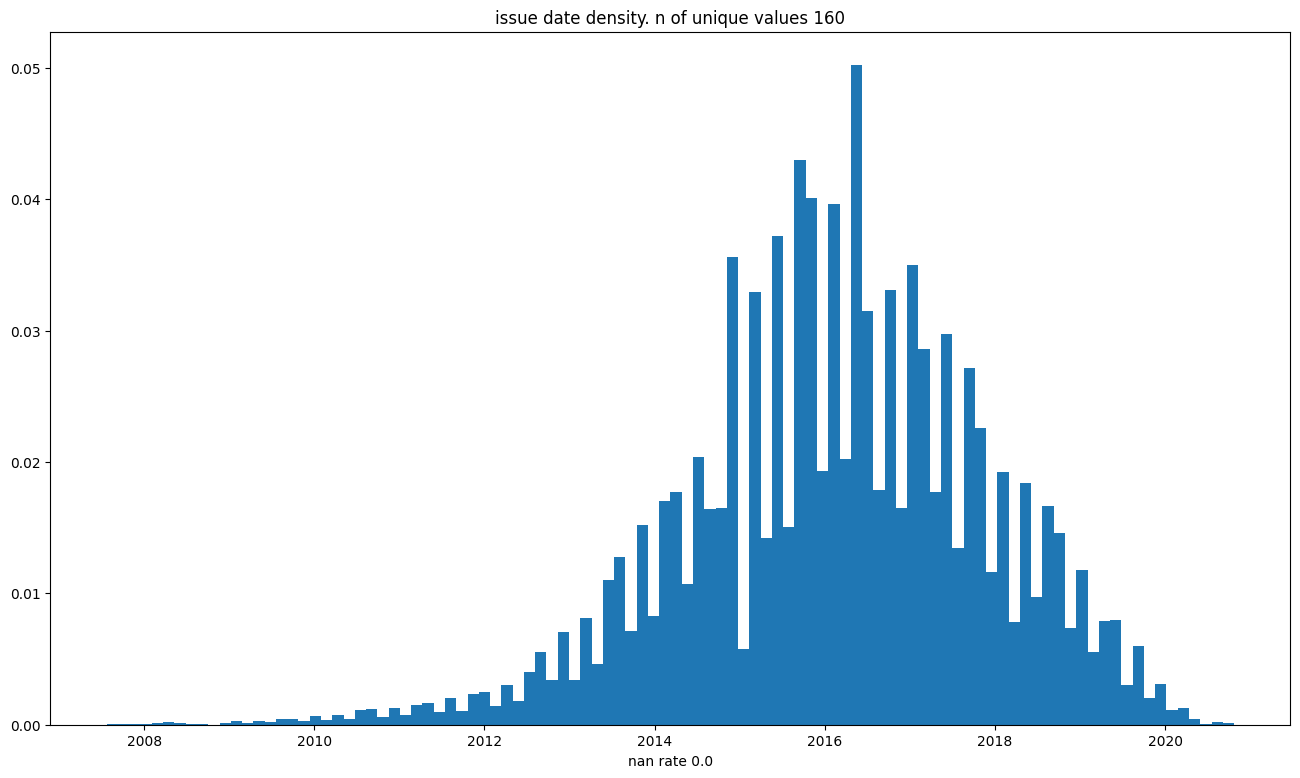

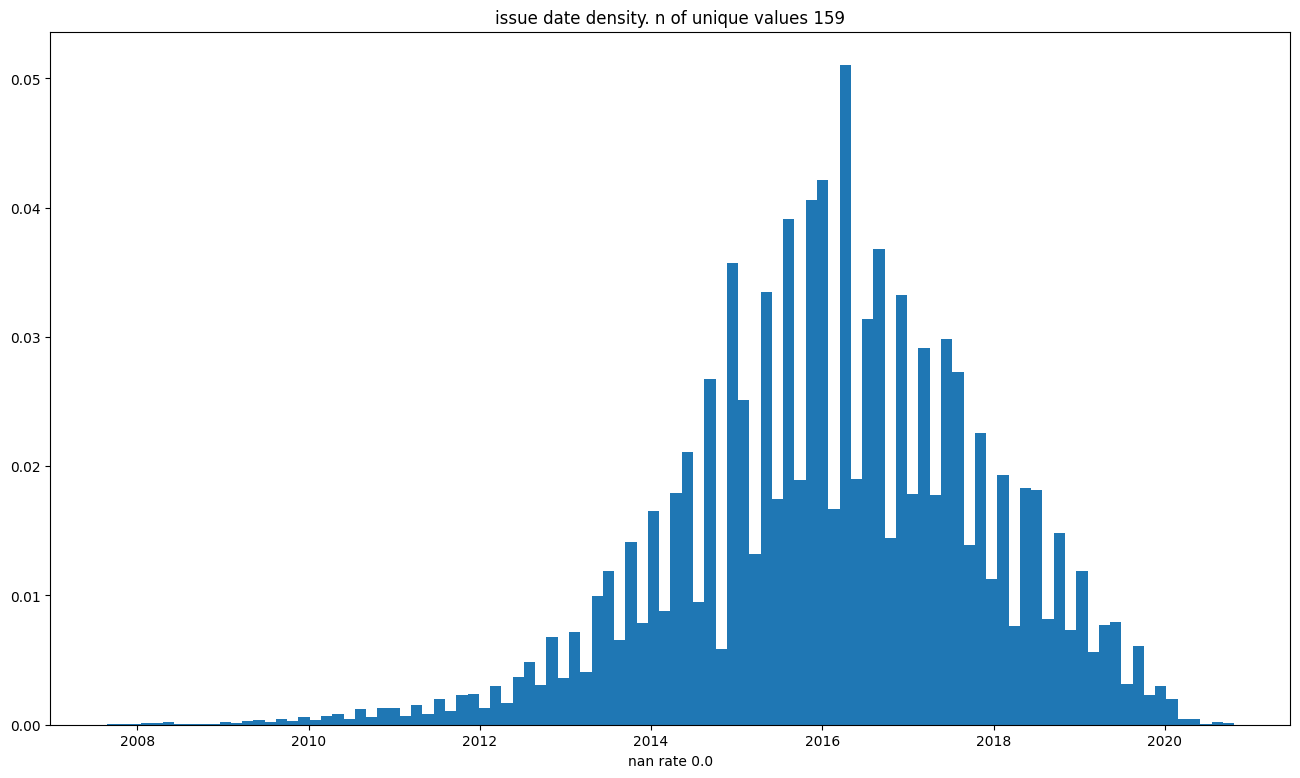

: 

In [2]:
X_train = pd.read_csv(conf.X_train_reformated,index_col=False)
Y_train = pd.read_csv(conf.train_target,index_col=False).drop(columns=['index'])
X_test = pd.read_csv(conf.X_test_reformated,index_col=False)
plot_float_distribution(X_train['issue_d'],(16,9),'issue date density')
plot_float_distribution(X_test['issue_d'],(16,9),'issue date density')

# group by time intervals

In [17]:
t_1,t_2 = get_min_max(X_train,'issue_d')
delta_t =  1.0
N = int((t_2-t_1)/delta_t)+1
time_bins = np.linspace(start=t_1,stop= t_2,num=N)
time_intervals = [(time_bins[i],time_bins[i+1]) for i in range(len(time_bins)-1)]
# plot_float_distribution(X_train['issue_d'],(16,9),'issue date density')
groups_by_time = group_by_time_interval(X_train,'issue_d',time_intervals)
lengts = [len(groups_by_time[k]) for k in groups_by_time]
print(lengts)

12/12
[740, 1597, 5166, 10766, 23705, 64091, 135349, 217901, 307458, 218984, 137030, 67076, 9998]


: 

In [16]:
print(get_min_max(X_train,'issue_d'))
print(get_min_max(X_test,'issue_d'))


(2007.495867768595, 2020.743801652893)
(2007.578512396694, 2020.743801652893)


# are distributions identical (by single feauture)

In [15]:
for i in range(len(time_intervals)-1):
    segment1 = time_intervals[i]
    segment2 = time_intervals[i+1]
    gr1 = groups_by_time[segment1]
    gr2 = groups_by_time[segment2]
    print('comparation grop {} group {}'.format(segment1,segment2))
    display(HTML(is_data_identical(gr1,gr2).to_html()))

comparation grop (2007.495867768595, 2008.5149396058487) group (2008.5149396058487, 2009.5340114431024)


,sim_count,diff_count,acc_now_delinq,addr_state,annual_inc,chargeoff_within_12_mths,collections_12_mths_ex_med,delinq_2yrs,dti,earliest_cr_line,emp_length,fico_range_high,fico_range_low,funded_amnt,home_ownership,index,inq_last_12m,installment,int_rate,issue_d,loan_amnt,mort_acc,mths_since_last_delinq,mths_since_recent_bc_dlq,mths_since_recent_inq,num_accts_ever_120_pd,num_actv_bc_tl,num_rev_accts,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,open_acc,open_il_24m,open_rv_24m,percent_bc_gt_75,pub_rec,pub_rec_bankruptcies,purpose,revol_util,tax_liens,term,title,total_acc,verification_status,zip_code
0,16,29,siml,diff,siml,siml,siml,siml,diff,diff,diff,siml,siml,diff,siml,diff,diff,diff,diff,diff,siml,diff,diff,diff,diff,diff,diff,diff,diff,diff,diff,diff,diff,siml,diff,diff,diff,siml,siml,diff,diff,siml,siml,siml,siml,diff,diff


comparation grop (2008.5149396058487, 2009.5340114431024) group (2009.5340114431024, 2010.553083280356)


,sim_count,diff_count,acc_now_delinq,addr_state,annual_inc,chargeoff_within_12_mths,collections_12_mths_ex_med,delinq_2yrs,dti,earliest_cr_line,emp_length,fico_range_high,fico_range_low,funded_amnt,home_ownership,index,inq_last_12m,installment,int_rate,issue_d,loan_amnt,mort_acc,mths_since_last_delinq,mths_since_recent_bc_dlq,mths_since_recent_inq,num_accts_ever_120_pd,num_actv_bc_tl,num_rev_accts,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,open_acc,open_il_24m,open_rv_24m,percent_bc_gt_75,pub_rec,pub_rec_bankruptcies,purpose,revol_util,tax_liens,term,title,total_acc,verification_status,zip_code
0,17,28,siml,siml,diff,siml,siml,siml,diff,siml,diff,siml,siml,diff,siml,siml,diff,diff,diff,diff,diff,diff,siml,diff,diff,diff,diff,diff,diff,diff,diff,diff,diff,siml,diff,diff,diff,siml,siml,diff,diff,siml,diff,siml,siml,diff,diff


comparation grop (2009.5340114431024, 2010.553083280356) group (2010.553083280356, 2011.5721551176098)


,sim_count,diff_count,acc_now_delinq,addr_state,annual_inc,chargeoff_within_12_mths,collections_12_mths_ex_med,delinq_2yrs,dti,earliest_cr_line,emp_length,fico_range_high,fico_range_low,funded_amnt,home_ownership,index,inq_last_12m,installment,int_rate,issue_d,loan_amnt,mort_acc,mths_since_last_delinq,mths_since_recent_bc_dlq,mths_since_recent_inq,num_accts_ever_120_pd,num_actv_bc_tl,num_rev_accts,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,open_acc,open_il_24m,open_rv_24m,percent_bc_gt_75,pub_rec,pub_rec_bankruptcies,purpose,revol_util,tax_liens,term,title,total_acc,verification_status,zip_code
0,12,33,siml,diff,diff,siml,siml,siml,diff,diff,diff,siml,siml,diff,diff,siml,diff,diff,diff,diff,diff,diff,diff,diff,diff,diff,diff,diff,diff,diff,diff,diff,diff,siml,diff,diff,diff,siml,siml,diff,diff,siml,diff,diff,diff,diff,siml


comparation grop (2010.553083280356, 2011.5721551176098) group (2011.5721551176098, 2012.5912269548635)


,sim_count,diff_count,acc_now_delinq,addr_state,annual_inc,chargeoff_within_12_mths,collections_12_mths_ex_med,delinq_2yrs,dti,earliest_cr_line,emp_length,fico_range_high,fico_range_low,funded_amnt,home_ownership,index,inq_last_12m,installment,int_rate,issue_d,loan_amnt,mort_acc,mths_since_last_delinq,mths_since_recent_bc_dlq,mths_since_recent_inq,num_accts_ever_120_pd,num_actv_bc_tl,num_rev_accts,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,open_acc,open_il_24m,open_rv_24m,percent_bc_gt_75,pub_rec,pub_rec_bankruptcies,purpose,revol_util,tax_liens,term,title,total_acc,verification_status,zip_code
0,9,36,siml,diff,diff,siml,siml,siml,diff,diff,diff,diff,diff,diff,siml,siml,diff,diff,diff,diff,diff,diff,diff,diff,diff,diff,diff,diff,diff,diff,diff,diff,diff,diff,diff,diff,diff,diff,siml,diff,diff,siml,diff,diff,diff,siml,diff


comparation grop (2011.5721551176098, 2012.5912269548635) group (2012.5912269548635, 2013.6102987921172)


,sim_count,diff_count,acc_now_delinq,addr_state,annual_inc,chargeoff_within_12_mths,collections_12_mths_ex_med,delinq_2yrs,dti,earliest_cr_line,emp_length,fico_range_high,fico_range_low,funded_amnt,home_ownership,index,inq_last_12m,installment,int_rate,issue_d,loan_amnt,mort_acc,mths_since_last_delinq,mths_since_recent_bc_dlq,mths_since_recent_inq,num_accts_ever_120_pd,num_actv_bc_tl,num_rev_accts,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,open_acc,open_il_24m,open_rv_24m,percent_bc_gt_75,pub_rec,pub_rec_bankruptcies,purpose,revol_util,tax_liens,term,title,total_acc,verification_status,zip_code
0,6,39,siml,diff,diff,siml,siml,diff,diff,diff,diff,diff,diff,diff,diff,siml,diff,diff,diff,diff,diff,diff,diff,diff,diff,diff,diff,diff,siml,diff,diff,diff,diff,diff,diff,diff,diff,diff,diff,diff,diff,siml,diff,diff,diff,diff,diff


comparation grop (2012.5912269548635, 2013.6102987921172) group (2013.6102987921172, 2014.6293706293707)


,sim_count,diff_count,acc_now_delinq,addr_state,annual_inc,chargeoff_within_12_mths,collections_12_mths_ex_med,delinq_2yrs,dti,earliest_cr_line,emp_length,fico_range_high,fico_range_low,funded_amnt,home_ownership,index,inq_last_12m,installment,int_rate,issue_d,loan_amnt,mort_acc,mths_since_last_delinq,mths_since_recent_bc_dlq,mths_since_recent_inq,num_accts_ever_120_pd,num_actv_bc_tl,num_rev_accts,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,open_acc,open_il_24m,open_rv_24m,percent_bc_gt_75,pub_rec,pub_rec_bankruptcies,purpose,revol_util,tax_liens,term,title,total_acc,verification_status,zip_code
0,5,40,siml,diff,diff,siml,diff,diff,diff,diff,diff,diff,diff,diff,diff,siml,diff,diff,diff,diff,diff,diff,diff,diff,diff,diff,diff,diff,diff,siml,siml,diff,diff,diff,diff,diff,diff,diff,diff,diff,diff,diff,diff,diff,diff,diff,diff


comparation grop (2013.6102987921172, 2014.6293706293707) group (2014.6293706293707, 2015.6484424666244)


,sim_count,diff_count,acc_now_delinq,addr_state,annual_inc,chargeoff_within_12_mths,collections_12_mths_ex_med,delinq_2yrs,dti,earliest_cr_line,emp_length,fico_range_high,fico_range_low,funded_amnt,home_ownership,index,inq_last_12m,installment,int_rate,issue_d,loan_amnt,mort_acc,mths_since_last_delinq,mths_since_recent_bc_dlq,mths_since_recent_inq,num_accts_ever_120_pd,num_actv_bc_tl,num_rev_accts,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,open_acc,open_il_24m,open_rv_24m,percent_bc_gt_75,pub_rec,pub_rec_bankruptcies,purpose,revol_util,tax_liens,term,title,total_acc,verification_status,zip_code
0,7,38,siml,diff,diff,siml,diff,diff,diff,diff,diff,diff,diff,diff,diff,siml,diff,diff,diff,diff,diff,diff,diff,diff,diff,diff,diff,diff,diff,siml,siml,siml,diff,diff,diff,diff,diff,diff,siml,diff,diff,diff,diff,diff,diff,diff,diff


comparation grop (2014.6293706293707, 2015.6484424666244) group (2015.6484424666244, 2016.667514303878)


,sim_count,diff_count,acc_now_delinq,addr_state,annual_inc,chargeoff_within_12_mths,collections_12_mths_ex_med,delinq_2yrs,dti,earliest_cr_line,emp_length,fico_range_high,fico_range_low,funded_amnt,home_ownership,index,inq_last_12m,installment,int_rate,issue_d,loan_amnt,mort_acc,mths_since_last_delinq,mths_since_recent_bc_dlq,mths_since_recent_inq,num_accts_ever_120_pd,num_actv_bc_tl,num_rev_accts,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,open_acc,open_il_24m,open_rv_24m,percent_bc_gt_75,pub_rec,pub_rec_bankruptcies,purpose,revol_util,tax_liens,term,title,total_acc,verification_status,zip_code
0,9,36,siml,diff,diff,siml,siml,siml,diff,diff,diff,diff,diff,diff,diff,siml,diff,diff,diff,diff,diff,diff,diff,diff,diff,siml,diff,diff,diff,siml,siml,siml,diff,diff,diff,diff,diff,diff,diff,diff,diff,diff,diff,diff,diff,diff,diff


comparation grop (2015.6484424666244, 2016.667514303878) group (2016.667514303878, 2017.6865861411318)


,sim_count,diff_count,acc_now_delinq,addr_state,annual_inc,chargeoff_within_12_mths,collections_12_mths_ex_med,delinq_2yrs,dti,earliest_cr_line,emp_length,fico_range_high,fico_range_low,funded_amnt,home_ownership,index,inq_last_12m,installment,int_rate,issue_d,loan_amnt,mort_acc,mths_since_last_delinq,mths_since_recent_bc_dlq,mths_since_recent_inq,num_accts_ever_120_pd,num_actv_bc_tl,num_rev_accts,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,open_acc,open_il_24m,open_rv_24m,percent_bc_gt_75,pub_rec,pub_rec_bankruptcies,purpose,revol_util,tax_liens,term,title,total_acc,verification_status,zip_code
0,9,36,siml,diff,diff,siml,siml,siml,diff,diff,diff,diff,diff,diff,diff,siml,diff,diff,diff,diff,diff,diff,diff,diff,diff,diff,diff,diff,diff,siml,siml,siml,diff,diff,diff,diff,diff,diff,diff,diff,diff,siml,diff,diff,diff,diff,diff


comparation grop (2016.667514303878, 2017.6865861411318) group (2017.6865861411318, 2018.7056579783855)


,sim_count,diff_count,acc_now_delinq,addr_state,annual_inc,chargeoff_within_12_mths,collections_12_mths_ex_med,delinq_2yrs,dti,earliest_cr_line,emp_length,fico_range_high,fico_range_low,funded_amnt,home_ownership,index,inq_last_12m,installment,int_rate,issue_d,loan_amnt,mort_acc,mths_since_last_delinq,mths_since_recent_bc_dlq,mths_since_recent_inq,num_accts_ever_120_pd,num_actv_bc_tl,num_rev_accts,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,open_acc,open_il_24m,open_rv_24m,percent_bc_gt_75,pub_rec,pub_rec_bankruptcies,purpose,revol_util,tax_liens,term,title,total_acc,verification_status,zip_code
0,7,38,diff,diff,siml,siml,siml,diff,diff,diff,diff,diff,diff,diff,diff,siml,diff,diff,diff,diff,diff,diff,diff,diff,diff,diff,diff,diff,diff,siml,siml,diff,diff,diff,diff,siml,diff,diff,diff,diff,diff,diff,diff,diff,diff,diff,diff


comparation grop (2017.6865861411318, 2018.7056579783855) group (2018.7056579783855, 2019.7247298156392)


,sim_count,diff_count,acc_now_delinq,addr_state,annual_inc,chargeoff_within_12_mths,collections_12_mths_ex_med,delinq_2yrs,dti,earliest_cr_line,emp_length,fico_range_high,fico_range_low,funded_amnt,home_ownership,index,inq_last_12m,installment,int_rate,issue_d,loan_amnt,mort_acc,mths_since_last_delinq,mths_since_recent_bc_dlq,mths_since_recent_inq,num_accts_ever_120_pd,num_actv_bc_tl,num_rev_accts,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,open_acc,open_il_24m,open_rv_24m,percent_bc_gt_75,pub_rec,pub_rec_bankruptcies,purpose,revol_util,tax_liens,term,title,total_acc,verification_status,zip_code
0,13,32,siml,siml,diff,siml,siml,siml,diff,diff,diff,diff,diff,diff,diff,siml,diff,diff,diff,diff,diff,diff,siml,siml,diff,diff,siml,diff,diff,siml,siml,siml,diff,diff,diff,diff,diff,diff,diff,diff,diff,diff,siml,diff,diff,diff,diff


comparation grop (2018.7056579783855, 2019.7247298156392) group (2019.7247298156392, 2020.743801652893)


,sim_count,diff_count,acc_now_delinq,addr_state,annual_inc,chargeoff_within_12_mths,collections_12_mths_ex_med,delinq_2yrs,dti,earliest_cr_line,emp_length,fico_range_high,fico_range_low,funded_amnt,home_ownership,index,inq_last_12m,installment,int_rate,issue_d,loan_amnt,mort_acc,mths_since_last_delinq,mths_since_recent_bc_dlq,mths_since_recent_inq,num_accts_ever_120_pd,num_actv_bc_tl,num_rev_accts,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,open_acc,open_il_24m,open_rv_24m,percent_bc_gt_75,pub_rec,pub_rec_bankruptcies,purpose,revol_util,tax_liens,term,title,total_acc,verification_status,zip_code
0,18,27,siml,siml,diff,siml,siml,siml,siml,diff,siml,diff,diff,diff,diff,siml,diff,diff,diff,diff,diff,diff,siml,siml,diff,siml,diff,diff,siml,siml,siml,siml,diff,siml,diff,diff,diff,diff,diff,diff,diff,siml,diff,diff,diff,diff,siml
